# DeepFace Detection 모델 비교 평가 - LFW 데이터셋

이 노트북은 DeepFace 라이브러리의 다양한 얼굴 detection 모델들을 LFW 데이터셋을 사용하여 비교 평가합니다.

## 평가 메트릭
- Detection 정확도
- Verification 정확도  
- 처리 속도
- 메모리 사용량
- 전력 소모량

In [1]:
# ===============================================================
# 1. 라이브러리 임포트 및 환경 설정
# ===============================================================
import os
import time
import gc
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# TensorFlow CPU 모드 강제 설정 (GPU 오류 방지)
print("⚙️ GPU 비활성화 및 CPU 모드 설정 중...")
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

try:
    from deepface import DeepFace
    print("✅ DeepFace 로딩 완료 (CPU 모드)")
except Exception as e:
    print(f"❌ DeepFace 로딩 실패: {e}")
    exit()

# 한글 폰트 설정
try:
    plt.rcParams['font.family'] = 'Malgun Gothic' # Windows
    plt.rcParams['axes.unicode_minus'] = False
    print("✅ 한글 폰트 '맑은 고딕'으로 설정됨")
except:
    print("⚠️ '맑은 고딕' 폰트 없음. 다른 폰트를 사용하거나 설치가 필요합니다.")

⚙️ GPU 비활성화 및 CPU 모드 설정 중...
✅ DeepFace 로딩 완료 (CPU 모드)
✅ 한글 폰트 '맑은 고딕'으로 설정됨


In [2]:
# ===============================================================
# 2. 경로 및 모델 설정
# ===============================================================
# !!! 사용자 환경에 맞게 LFW 데이터셋 경로를 수정해주세요 !!!
# 예: "C:/Users/Admin/Downloads/lfw-deepfunneled/"
# LFW_IMAGE_PATH: 'Abel_Pacheco', 'George_W_Bush' 등 사람 이름 폴더가 있는 경로
# 예: "C:/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled"
LFW_IMAGE_PATH = "/mnt/c/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled"

# PAIRS_FILE_PATH: 'pairs.csv' 파일의 전체 경로
# 예: "C:/Users/Admin/Downloads/lfw-deepfunneled/pairs.csv"
PAIRS_FILE_PATH = "/mnt/c/Users/Admin/Downloads/lfw-deepfunneled/pairs.csv"

# 테스트할 Detection 모델 목록
DETECTION_MODELS = [
    'opencv', 'mtcnn', 
    'yolov8', 'yunet',
    'yolov11n', 'centerface',
]

# DETECTION_MODELS = [
#     'yolov8', 'yolov11n', 'yunet', 'fastmtcnn','centerface', 'retinaface'
# ]

# 테스트할 Recognition 모델 (Verification 정확도 측정 시 사용)
RECOGNITION_MODEL = 'VGG-Face'

# 테스트할 이미지 쌍의 최대 개수 (시간 단축을 위해)
MAX_TEST_PAIRS = 6000

In [3]:
print("\n🔍 경로 설정 검증 시작...")

# 1. pairs.csv 파일 존재 여부 확인
if os.path.exists(PAIRS_FILE_PATH):
    print(f"  ✅ [성공] pairs.csv 파일을 찾았습니다: {PAIRS_FILE_PATH}")
else:
    print(f"  ❌ [실패] pairs.csv 파일을 찾을 수 없습니다! PAIRS_FILE_PATH 변수를 확인해주세요.")
    exit()

# 2. 이미지 폴더 존재 여부 확인
if os.path.isdir(LFW_IMAGE_PATH):
    print(f"  ✅ [성공] 이미지 기본 폴더를 찾았습니다: {LFW_IMAGE_PATH}")
else:
    print(f"  ❌ [실패] 이미지 기본 폴더를 찾을 수 없습니다! LFW_IMAGE_PATH 변수를 확인해주세요.")
    exit()

# 3. 특정 샘플 이미지 파일 존재 여부 확인
# LFW 데이터셋에 항상 존재하는 샘플로 경로를 조합하여 테스트합니다.
sample_person = "George_W_Bush"
sample_image_num = 1
sample_image_filename = f"{sample_person}_{sample_image_num:04d}.jpg"
expected_image_path = os.path.join(LFW_IMAGE_PATH, sample_person, sample_image_filename)

if os.path.exists(expected_image_path):
    print(f"  ✅ [성공] 샘플 이미지 파일을 찾았습니다: {expected_image_path}")
else:
    print(f"  ❌ [실패] 샘플 이미지 파일을 찾을 수 없습니다!")
    print(f"     - 현재 LFW_IMAGE_PATH 설정: '{LFW_IMAGE_PATH}'")
    print(f"     - 이 경로 안에 '{sample_person}' 폴더와 그 안에 '{sample_image_filename}' 파일이 있는지 확인해주세요.")
    exit()

print("👍 모든 경로가 유효합니다. 데이터 로딩을 계속합니다.")


🔍 경로 설정 검증 시작...
  ✅ [성공] pairs.csv 파일을 찾았습니다: /mnt/c/Users/Admin/Downloads/lfw-deepfunneled/pairs.csv
  ✅ [성공] 이미지 기본 폴더를 찾았습니다: /mnt/c/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled
  ✅ [성공] 샘플 이미지 파일을 찾았습니다: /mnt/c/Users/Admin/Downloads/lfw-deepfunneled/lfw-deepfunneled/George_W_Bush/George_W_Bush_0001.jpg
👍 모든 경로가 유효합니다. 데이터 로딩을 계속합니다.


In [4]:
# ===============================================================
# 3. 데이터 로딩 (최종 수정안)
# ===============================================================
def get_lfw_image_path(person, image_num):
    """LFW 데이터셋의 이미지 경로를 생성하는 함수"""
    # .jpg가 없는 경우를 대비해 예외 처리
    try:
        return os.path.join(LFW_IMAGE_PATH, person, f"{person}_{int(image_num):04d}.jpg")
    except ValueError:
        return None # 숫자로 변환할 수 없는 값인 경우 None 반환

print(f"\n📁 데이터 로딩 시작...")

try:
    # ❗️❗️❗️ 변경된 부분: 구분자를 쉼표(,)로 명시 ❗️❗️❗️
    pairs_df = pd.read_csv(PAIRS_FILE_PATH, sep=',', header=None)
    # 첫 줄의 설명(예: 10 300)을 건너뛰기 위해 iloc 사용
    pairs_df = pairs_df.iloc[1:]
    print("✅ pairs.csv 파일 로딩 성공 (쉼표 구분자로 처리)")
except Exception as e:
    print(f"❌ '{PAIRS_FILE_PATH}' 파일 읽기 중 오류 발생: {e}")
    exit()

image_pairs = []
true_labels = []

# 전체 데이터프레임을 순회하며 데이터 처리
for index, row in pairs_df.iterrows():
    # 마지막 열이 비어있는(NaN) 경우, 일치하는 쌍으로 간주 (열 3개)
    # Abel_Pacheco,1,4, -> [Abel_Pacheco, 1, 4, NaN] 으로 읽힘
    if pd.isna(row[3]): 
        person, img1_num, img2_num = row[0], row[1], row[2]
        img1_path = get_lfw_image_path(person, img1_num)
        img2_path = get_lfw_image_path(person, img2_num)
        
        if img1_path and img2_path and os.path.exists(img1_path) and os.path.exists(img2_path):
            image_pairs.append((img1_path, img2_path))
            true_labels.append(1)  # 1은 '일치'

    # 마지막 열에 값이 있는 경우, 불일치하는 쌍으로 간주 (열 4개)
    else:
        person1, img1_num, person2, img2_num = row[0], row[1], row[2], row[3]
        img1_path = get_lfw_image_path(person1, img1_num)
        img2_path = get_lfw_image_path(person2, img2_num)

        if img1_path and img2_path and os.path.exists(img1_path) and os.path.exists(img2_path):
            image_pairs.append((img1_path, img2_path))
            true_labels.append(0)  # 0은 '불일치'

print(f"✅ 총 {len(image_pairs)}개의 유효한 이미지 쌍 로드 완료.")
if len(image_pairs) > 0:
    print(f"   - 이 중 최대 {MAX_TEST_PAIRS}개를 테스트합니다.")
else:
    print(f"   ⚠️ 로드된 이미지 쌍이 없습니다. PAIRS_FILE_PATH의 내용과 LFW_IMAGE_PATH의 폴더 구조를 다시 확인해주세요.")


📁 데이터 로딩 시작...
✅ pairs.csv 파일 로딩 성공 (쉼표 구분자로 처리)
✅ 총 6000개의 유효한 이미지 쌍 로드 완료.
   - 이 중 최대 6000개를 테스트합니다.


In [ ]:
# ===============================================================
# 4. 성능 측정 함수
# ===============================================================
def measure_memory_usage():
    """현재 프로세스의 메모리 사용량 측정 (MB)"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def test_model_performance(model_name, image_pairs, true_labels, max_pairs):
    """단일 모델의 Detection 및 Verification 성능 측정"""
    print(f"\n🚀 === '{model_name}' 모델 테스트 시작 === 🚀")
    
    # 테스트 데이터 제한
    test_pairs = image_pairs[:max_pairs]
    test_labels = true_labels[:max_pairs]

    # 결과 저장을 위한 변수 초기화
    detection_times = []
    verification_times = []
    
    detection_success_count = 0
    total_images_tested = 0
    
    verification_pairs_indices = [] # Detection 성공한 쌍의 인덱스
    verification_predictions = []
    
    # 오류 분석용 변수
    detection_failures = 0 # 얼굴을 아예 못 찾음 (detector 실패)
    invalid_outputs = 0    # 얼굴은 찾았으나 후처리 실패 (빈 배열)

    # tqdm으로 진행률 표시
    for i, (img1_path, img2_path) in enumerate(tqdm(test_pairs, desc=f"Testing {model_name}")):
        total_images_tested += 2
        pair_detection_successful = True

        # --- Detection 테스트 (이미지 1) ---
        detection_start = time.time()
        try:
            # enforce_detection=False로 설정하여 예외 대신 빈 리스트 반환
            faces1 = DeepFace.extract_faces(
                img_path=img1_path, 
                detector_backend=model_name,
                enforce_detection=False,
                align=True 
            )
            # 반환값이 리스트이고, 비어있지 않으며, 내부 배열이 유효한지 확인
            if faces1 and isinstance(faces1, list) and len(faces1) > 0 and faces1[0]['face'].size > 0:
                detection_success_count += 1
            else:
                pair_detection_successful = False
                if not faces1:
                    detection_failures += 1
                else:
                    invalid_outputs +=1

        except Exception:
            pair_detection_successful = False
            invalid_outputs += 1 # 예측 불가능한 오류는 무효 출력으로 처리
        detection_times.append(time.time() - detection_start)

        # --- Detection 테스트 (이미지 2) ---
        detection_start = time.time()
        try:
            faces2 = DeepFace.extract_faces(
                img_path=img2_path, 
                detector_backend=model_name,
                enforce_detection=False,
                align=True
            )
            if faces2 and isinstance(faces2, list) and len(faces2) > 0 and faces2[0]['face'].size > 0:
                detection_success_count += 1
            else:
                pair_detection_successful = False
                if not faces2:
                    detection_failures += 1
                else:
                    invalid_outputs +=1
        except Exception:
            pair_detection_successful = False
            invalid_outputs += 1
        detection_times.append(time.time() - detection_start)
        
        # --- Verification 테스트 (두 이미지 모두 Detection 성공 시) ---
        if pair_detection_successful:
            verification_start = time.time()
            try:
                result = DeepFace.verify(
                    img1_path=img1_path,
                    img2_path=img2_path,
                    detector_backend=model_name,
                    model_name=RECOGNITION_MODEL,
                    enforce_detection=True # 이미 성공했으므로 True로 설정
                )
                verification_pairs_indices.append(i)
                verification_predictions.append(1 if result['verified'] else 0)
            except Exception:
                # Verification 단계에서 오류 발생 시 해당 쌍은 정확도 계산에서 제외
                pass
            verification_times.append(time.time() - verification_start)
    
    # --- 결과 계산 ---
    detection_accuracy = detection_success_count / total_images_tested if total_images_tested > 0 else 0
    
    verification_accuracy = 0
    if verification_pairs_indices:
        valid_true_labels = [test_labels[i] for i in verification_pairs_indices]
        from sklearn.metrics import accuracy_score
        verification_accuracy = accuracy_score(valid_true_labels, verification_predictions)
    
    # --- End-to-End Accuracy 계산 (Detection 실패도 반영) ---
    # Detection 실패 시 해당 쌍은 verification 실패로 간주
    total_pairs = len(test_pairs)
    correct_verifications = sum([1 for i, pred in zip(verification_pairs_indices, verification_predictions) 
                                  if pred == test_labels[i]])
    end_to_end_accuracy = correct_verifications / total_pairs if total_pairs > 0 else 0

    # --- 결과 정리 및 출력 ---
    result_summary = {
        'model': model_name,
        'detection_accuracy': detection_accuracy,
        'verification_accuracy': verification_accuracy,
        'end_to_end_accuracy': end_to_end_accuracy,
        'avg_detection_time': np.mean(detection_times) if detection_times else 0,
        'avg_verification_time': np.mean(verification_times) if verification_times else 0,
        'detection_failures': detection_failures,
        'invalid_outputs': invalid_outputs
    }

    print(f"  - ✅ 테스트 완료!")
    print(f"  - 👤 Detection 성공률: {detection_accuracy:.2%}")
    print(f"  - 🔍 Verification 정확도 (Detection 성공 쌍 대상): {verification_accuracy:.2%}")
    print(f"  - 🎯 End-to-End 정확도 (전체 파이프라인): {end_to_end_accuracy:.2%}")
    print(f"  - ⏱️ 평균 Detection 시간: {result_summary['avg_detection_time']:.4f}초")
    print(f"  - ⏱️ 평균 Verification 시간: {result_summary['avg_verification_time']:.4f}초")
    print(f"  - ❌ 얼굴 탐지 실패 (Detector): {detection_failures}건")
    print(f"  - ⚠️ 무효한 출력 (빈 배열 등): {invalid_outputs}건")

    return result_summary

In [ ]:
# ===============================================================
# 5. 모든 모델 테스트 실행
# ===============================================================
all_results = []
baseline_memory = measure_memory_usage()

for model in DETECTION_MODELS:
    # 모델별 메모리 사용량 측정을 위해 가비지 컬렉션
    gc.collect()
    
    # 모델 테스트 시작 전 메모리
    before_memory = measure_memory_usage()
    
    result = test_model_performance(model, image_pairs, true_labels, max_pairs=MAX_TEST_PAIRS)
    
    # 모델 테스트 후 메모리
    after_memory = measure_memory_usage()
    result['memory_usage_mb'] = after_memory - baseline_memory  # 전체 베이스라인 대비
    result['memory_delta_mb'] = after_memory - before_memory    # 해당 모델의 증분
    all_results.append(result)
    
    # 일부 모델은 메모리 해제가 잘 안될 수 있으므로 잠시 대기
    time.sleep(2)

print("\n\n🎉 모든 모델 테스트 완료!")




📊 === 최종 성능 비교표 (Detection 성공률 기준 정렬) === 📊
     model  detection_accuracy  verification_accuracy  avg_detection_time  avg_verification_time  detection_failures  invalid_outputs  memory_usage_mb
    opencv              1.0000                 0.8948              0.0214                 0.1945                   0                0        1531.8008
     mtcnn              1.0000                 0.9379              0.0768                 0.3147                   0                0          57.4297
    yolov8              1.0000                 0.9423              0.0390                 0.2657                   0                0         620.8477
     yunet              1.0000                 0.9454              0.0162                 0.1838                   0                0           2.2227
  yolov11n              1.0000                 0.9402              0.0390                 0.2725                   0                0          40.3867
centerface              1.0000                 0

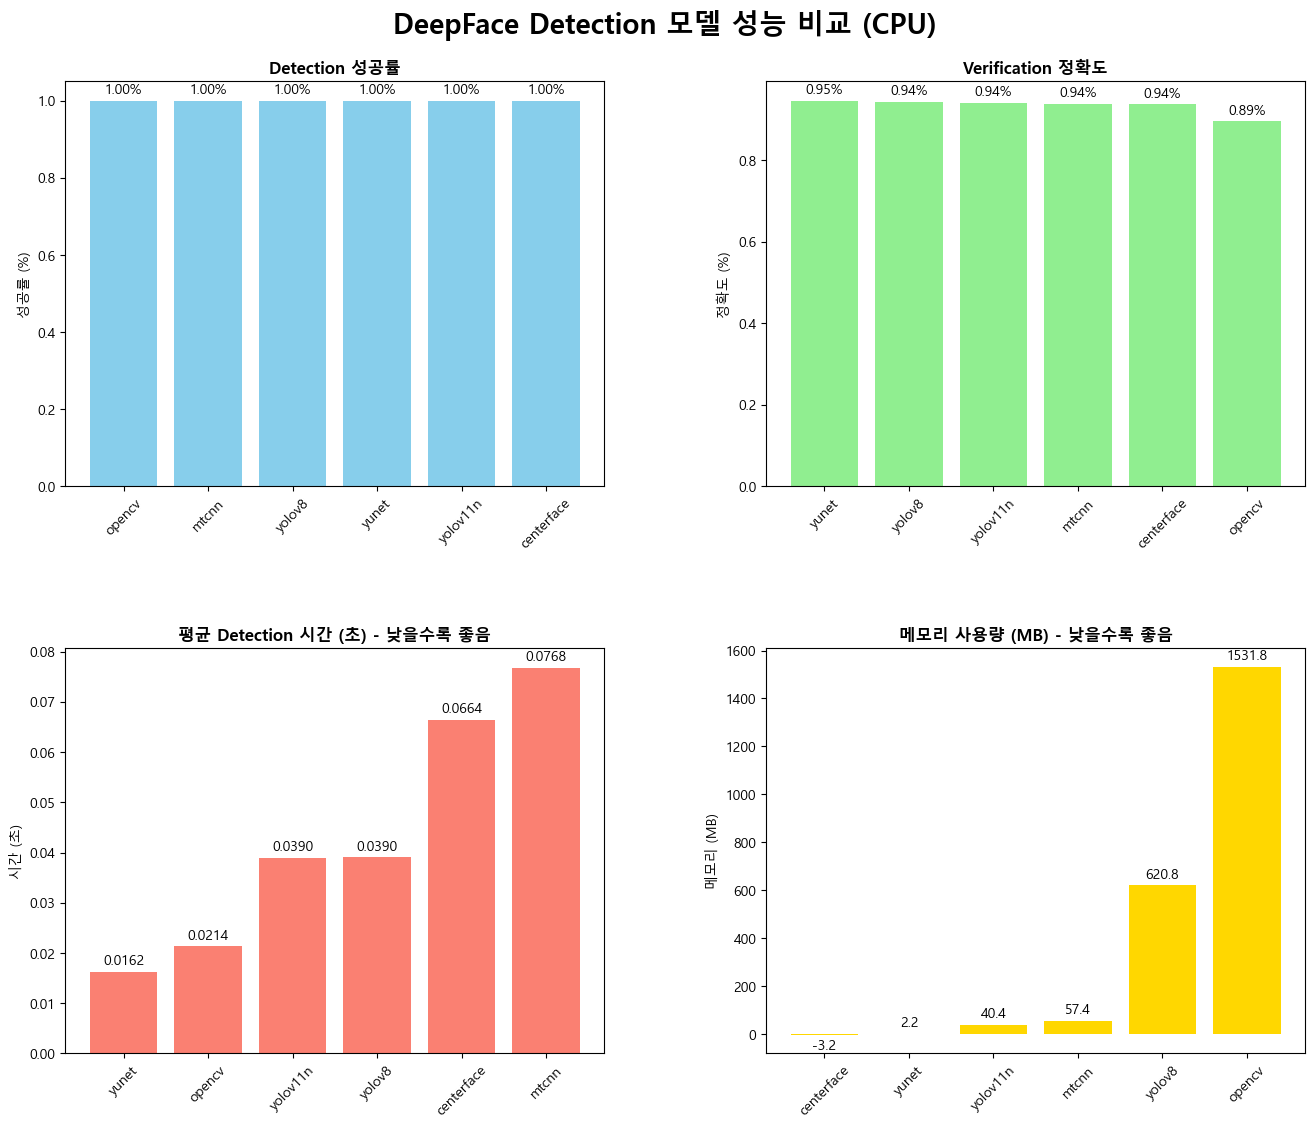


✅ 결과가 'deepface_benchmark_results.csv' 파일로 저장되었습니다.


In [7]:
# ===============================================================
# 6. 결과 정리 및 시각화
# ===============================================================
df_results = pd.DataFrame(all_results)
df_results_sorted = df_results.sort_values(by='detection_accuracy', ascending=False)

print("\n\n📊 === 최종 성능 비교표 (Detection 성공률 기준 정렬) === 📊")
print(df_results_sorted.to_string(index=False, float_format="%.4f"))

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DeepFace Detection 모델 성능 비교 (CPU)', fontsize=20, fontweight='bold')
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)

# 1. Detection 정확도
ax1 = axes[0, 0]
sorted_df = df_results.sort_values('detection_accuracy', ascending=False)
bars1 = ax1.bar(sorted_df['model'], sorted_df['detection_accuracy'], color='skyblue')
ax1.set_title('Detection 성공률', fontweight='bold')
ax1.set_ylabel('성공률 (%)')
ax1.tick_params(axis='x', rotation=45)
ax1.bar_label(bars1, fmt='%.2f%%', padding=3)

# 2. Verification 정확도
ax2 = axes[0, 1]
sorted_df = df_results.sort_values('verification_accuracy', ascending=False)
bars2 = ax2.bar(sorted_df['model'], sorted_df['verification_accuracy'], color='lightgreen')
ax2.set_title('Verification 정확도', fontweight='bold')
ax2.set_ylabel('정확도 (%)')
ax2.tick_params(axis='x', rotation=45)
ax2.bar_label(bars2, fmt='%.2f%%', padding=3)

# 3. 평균 Detection 시간
ax3 = axes[1, 0]
sorted_df = df_results.sort_values('avg_detection_time', ascending=True)
bars3 = ax3.bar(sorted_df['model'], sorted_df['avg_detection_time'], color='salmon')
ax3.set_title('평균 Detection 시간 (초) - 낮을수록 좋음', fontweight='bold')
ax3.set_ylabel('시간 (초)')
ax3.tick_params(axis='x', rotation=45)
ax3.bar_label(bars3, fmt='%.4f', padding=3)

# 4. 메모리 사용량
ax4 = axes[1, 1]
sorted_df = df_results.sort_values('memory_usage_mb', ascending=True)
bars4 = ax4.bar(sorted_df['model'], sorted_df['memory_usage_mb'], color='gold')
ax4.set_title('메모리 사용량 (MB) - 낮을수록 좋음', fontweight='bold')
ax4.set_ylabel('메모리 (MB)')
ax4.tick_params(axis='x', rotation=45)
ax4.bar_label(bars4, fmt='%.1f', padding=3)

plt.show()

# 결과 CSV 파일로 저장
output_filename = "deepface_benchmark_results.csv"
df_results.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"\n✅ 결과가 '{output_filename}' 파일로 저장되었습니다.")

In [ ]:
# --- 레이더 차트 생성을 위한 데이터 정규화 ---
df_normalized = df_results.copy()
# 정확도 항목은 값이 클수록 좋으므로 그대로 사용
df_normalized['norm_detection'] = df_normalized['detection_accuracy']
df_normalized['norm_end_to_end'] = df_normalized['end_to_end_accuracy']

# 시간, 메모리, 전력은 값이 작을수록 좋으므로 (1 - 정규화) 처리
# 0으로 나누는 것을 방지하기 위해 분모가 0일 경우 0으로 처리
max_time = df_normalized['avg_detection_time'].max()
df_normalized['norm_speed'] = 1 - (df_normalized['avg_detection_time'] / max_time) if max_time > 0 else 0

max_memory = df_normalized['memory_usage_mb'].max()
df_normalized['norm_memory'] = 1 - (df_normalized['memory_usage_mb'] / max_memory) if max_memory > 0 else 0

metrics = ['detection', 'end_to_end', 'speed', 'memory']


# --- 가중 평균으로 종합 점수 계산 ---
weights = {'detection': 0.2, 'end_to_end': 0.4, 'speed': 0.2, 'memory': 0.1,}
df_normalized['composite_score'] = (
    df_normalized['norm_detection'] * weights['detection'] +
    df_normalized['norm_end_to_end'] * weights['end_to_end'] +
    df_normalized['norm_speed'] * weights['speed'] +
    df_normalized['norm_memory'] * weights['memory']
)

df_ranked = df_normalized.sort_values(by='composite_score', ascending=False)

print("\n\n📊 === 최종 성능 비교표 (종합 점수 기준 정렬) === 📊")
display(df_ranked[['model', 'detection_accuracy', 'verification_accuracy', 'end_to_end_accuracy', 'avg_detection_time', 'memory_usage_mb', 'composite_score']].round(3))


# --- 레이더 차트 시각화 ---
from math import pi

top_5_models = df_ranked.head(5)
categories = [m.capitalize().replace('_', '-') for m in metrics]
N = len(categories)

# 각도 계산
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# 축 레이블 설정
plt.xticks(angles[:-1], categories, size=12)

# y축 레이블 설정
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.50", "0.75", "1.00"], color="grey", size=10)
plt.ylim(0, 1)

# 각 모델의 데이터 플롯
for i, (index, row) in enumerate(top_5_models.iterrows()):
    data = row[['norm_'+m for m in metrics]].values.flatten().tolist()
    data += data[:1]
    ax.plot(angles, data, linewidth=2, linestyle='solid', label=row['model'])
    ax.fill(angles, data, alpha=0.1)

plt.title('상위 5개 모델 종합 성능 비교 (레이더 차트)', size=16, fontweight='bold', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()
